# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV942"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 15

In [5]:
# OUTPUT_FIGURES_DIR = Path(
#     conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
# ).resolve()
# display(OUTPUT_FIGURES_DIR)
# OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [6]:
# OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
# display(OUTPUT_CELL_TYPE_FILEPATH)

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases/phenoplier/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-09-29 14:49:24,626 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR
2071,Custom_Treg,942,0.998441,0.002270,0.014751
2073,SVM T cells CD4 memory activated,942,0.878270,0.000008,0.000121
2076,PID_NFAT_TFPATHWAY,942,0.802124,0.000290,0.002656


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP059057, SRP060416, SRP049462, SRP061932, SRP053186, SRP056049, SRP055675, SRP055569, SRP043339, SRP061881, SRP055474, SRP033466, SRP045570, SRP045052, SRP010644, SRP051736, SRP044286, SRP058719, SRP037735, SRP042161, SRP053046, SRP065988, SRP057196, SRP039591, SRP050499, SRP009105, SRP051737, SRP045569, SRP045500, SRP007947, SRP062958, SRP048971, SRP042218, SRP040328, SRP003901, SRP064464, SRP043080, SRP066834, 

In [19]:
lv_data.shape

(4386, 70)

In [20]:
lv_data.head()

cell stimulation  \
project   run                                                       
SRP059057 SRR2050410                                 Unstimulated   
          SRR2050427  Phorbal myristate acetate (PMA) stimulation   
          SRR2050426               anti-CD3/anti-CD28 stimulation   
          SRR2050425                                 Unstimulated   
          SRR2050424  Phorbal myristate acetate (PMA) stimulation   

                               phenotype tonsil donor facs gating cell type  \
project   run                                                                 
SRP059057 SRR2050410  Coeliac Individual          NaN         NaN       NaN   
          SRR2050427  Coeliac Individual          NaN         NaN       NaN   
          SRR2050426  Coeliac Individual          NaN         NaN       NaN   
          SRR2050425  Coeliac Individual          NaN         NaN       NaN   
          SRR2050424  Coeliac Individual          NaN         NaN       NaN   

                     activation passages bardcode tissue culture condition  \
project   run                                                                
SRP059057 SRR2050410        NaN      NaN      NaN    NaN               NaN   
          SRR2050427        NaN      NaN      NaN    NaN               NaN   
          SRR2050426        NaN      NaN      NaN    NaN               NaN   
          SRR2050425        NaN      NaN      NaN    NaN               NaN   
          SRR2050424        NaN      NaN      NaN    NaN               NaN   

                      ... tumor stage assigned cell type qc pass cell count  \
project   run         ...                                                     
SRP059057 SRR2050410  ...         NaN                NaN     NaN        NaN   
          SRR2050427  ...         NaN                NaN     NaN        NaN   
          SRR2050426  ...         NaN                NaN     NaN        NaN   
          SRR2050425  ...         NaN                NaN     NaN        NaN   
          SRR2050424  ...         NaN                NaN     NaN        NaN   

                     ercc_mix ercc_dilution donor time Stage     LV942  
project   run                                                           
SRP059057 SRR2050410      NaN           NaN   NaN  NaN   NaN  0.324439  
          SRR2050427      NaN           NaN   NaN  NaN   NaN  1.097670  
          SRR2050426      NaN           NaN   NaN  NaN   NaN  0.608384  
          SRR2050425      NaN           NaN   NaN  NaN   NaN  0.338935  
          SRR2050424      NaN           NaN   NaN  NaN   NaN  1.510119  

[5 rows x 70 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

cell stimulation         0.258165
phenotype                0.258165
activation               0.052328
passages                 0.048801
bardcode                 0.048801
cell-culture-batch       0.040878
group                    0.040878
cell population          0.039936
p/i stimulation          0.033345
ectopic expression       0.033345
overexpression           0.031896
genotype                 0.027888
diagnosis                0.024438
treatment                0.024233
antibody                 0.020791
differentiation stage    0.020791
t cell type              0.018811
cell surface markers     0.018811
cell line                0.015834
facs gating              0.015281
dtype: float64

In [26]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:cell.+$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell stimulation        0.258165
cell-culture-batch      0.040878
cell population         0.039936
cell surface markers    0.018811
cell line               0.015834
cell markers            0.013589
tissue                  0.012158
cell type               0.011742
celltype                0.007628
cellcount               0.006609
cell state              0.002567
cell count              0.001148
dtype: float64

In [27]:
_tmp = lv_data.loc[
    :,
    [
        "cell stimulation",
        "cell line",
        "tissue",
        "cell type",
        LV_NAME,
    ],
]

In [28]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [37]:
_tmp_seq[2]

cell stimulation cell line      tissue  \
project   run                                                                
SRP059057 SRR2050417  anti-CD3/anti-CD28 stimulation       NaN         NaN   
SRP053186 SRR1786593                             NaN       NaN         NaN   
SRP055675 SRR1822125                             NaN       NaN         NaN   
SRP053186 SRR1786590                             NaN       NaN         NaN   
SRP059057 SRR2050420  anti-CD3/anti-CD28 stimulation       NaN         NaN   
          SRR2050439                    Unstimulated       NaN         NaN   
          SRR2050403  anti-CD3/anti-CD28 stimulation       NaN         NaN   
SRP053186 SRR1786607                             NaN       NaN         NaN   
SRP061932 SRR2141378                             NaN       NaN  cord blood   
          SRR2141380                             NaN       NaN  cord blood   
          SRR2141381                             NaN       NaN  cord blood   
SRP053186 SRR1786597                             NaN       NaN         NaN   
          SRR1786591                             NaN       NaN         NaN   
          SRR1786598                             NaN       NaN         NaN   
SRP061932 SRR2141377                             NaN       NaN  cord blood   
SRP053186 SRR1786584                             NaN       NaN         NaN   
SRP059057 SRR2050426  anti-CD3/anti-CD28 stimulation       NaN         NaN   
          SRR2050434  anti-CD3/anti-CD28 stimulation       NaN         NaN   
SRP061932 SRR2141379                             NaN       NaN  cord blood   
SRP055675 SRR1822126                             NaN       NaN         NaN   
SRP053186 SRR1786603                             NaN       NaN         NaN   
          SRR1786594                             NaN       NaN         NaN   
SRP055675 SRR1822123                             NaN       NaN         NaN   
SRP061932 SRR2141376                             NaN       NaN  cord blood   
SRP055569 SRR1821557                             NaN       NaN         NaN   

                                                              cell type  \
project   run                                                             
SRP059057 SRR2050417                                                NaN   
SRP053186 SRR1786593                                                NaN   
SRP055675 SRR1822125                                 regulatory T cells   
SRP053186 SRR1786590                                                NaN   
SRP059057 SRR2050420                                                NaN   
          SRR2050439                                                NaN   
          SRR2050403                                                NaN   
SRP053186 SRR1786607                                                NaN   
SRP061932 SRR2141378                                       CD4+ T cells   
          SRR2141380                                       CD4+ T cells   
          SRR2141381                                       CD4+ T cells   
SRP053186 SRR1786597                                                NaN   
          SRR1786591                                                NaN   
          SRR1786598                                                NaN   
SRP061932 SRR2141377                                       CD4+ T cells   
SRP053186 SRR1786584                                                NaN   
SRP059057 SRR2050426                                                NaN   
          SRR2050434                                                NaN   
SRP061932 SRR2141379                                       CD4+ T cells   
SRP055675 SRR1822126                                 regulatory T cells   
SRP053186 SRR1786603                                                NaN   
          SRR1786594                                                NaN   
SRP055675 SRR1822123                                 regulatory T cells   
SRP061932 SRR2141376                                  

In [40]:
# what is there in these projects?
lv_data.loc[["SRP053186"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(20)

culture condition  \
project   run                                                            
SRP053186 SRR1786604  3 day in vitro culture for Th0, treatment (IL27)   
          SRR1786593                    3 day in vitro culture for Th0   
          SRR1786590                    3 day in vitro culture for Th0   
          SRR1786607  3 day in vitro culture for Th0, treatment (IL27)   
          SRR1786597   3 day in vitro culture for Th0, treatment (IL6)   
          SRR1786591   3 day in vitro culture for Th0, treatment (IL6)   
          SRR1786598  3 day in vitro culture for Th0, treatment (IL27)   
          SRR1786584                    3 day in vitro culture for Th0   
          SRR1786603   3 day in vitro culture for Th0, treatment (IL6)   
          SRR1786594   3 day in vitro culture for Th0, treatment (IL6)   
          SRR1786602                    3 day in vitro culture for Th0   
          SRR1786592  3 day in vitro culture for Th0, treatment (IL27)   
          SRR1786583  3 day in vitro culture for Th0, treatment (IL27)   
          SRR1786606   3 day in vitro culture for Th0, treatment (IL6)   
          SRR1786605                    3 day in vitro culture for Th0   
          SRR1786596                    3 day in vitro culture for Th0   
          SRR1786601  3 day in vitro culture for Th0, treatment (IL27)   
          SRR1786581                    3 day in vitro culture for Th0   
          SRR1786585   3 day in vitro culture for Th0, treatment (IL6)   
          SRR1786582   3 day in vitro culture for Th0, treatment (IL6)   

                                 genotype lab data id     LV942  
project   run                                                    
SRP053186 SRR1786604  STAT1 GOF patient 4         843  0.711629  
          SRR1786593  STAT1 GOF patient 1         621  0.676540  
          SRR1786590    healthy control 4         835  0.645509  
          SRR1786607  STAT1 GOF patient 5         846  0.633646  
          SRR1786597  STAT1 GOF patient 2         796  0.615740  
          SRR1786591    healthy control 4         836  0.614710  
          SRR1786598  STAT1 GOF patient 2         797  0.614401  
          SRR1786584    healthy control 2         786  0.609222  
          SRR1786603  STAT1 GOF patient 4         842  0.601418  
          SRR1786594  STAT1 GOF patient 1         622  0.595905  
          SRR1786602  STAT1 GOF patient 4         841  0.567252  
          SRR1786592    healthy control 4         837  0.566773  
          SRR1786583    healthy control 1         695  0.561507  
          SRR1786606  STAT1 GOF patient 5         845  0.550902  
          SRR1786605  STAT1 GOF patient 5         844  0.525266  
          SRR1786596  STAT1 GOF patient 2         795  0.524128  
          SRR1786601  STAT1 GOF patient 3         840  0.523570  
          SRR1786581    healthy control 1         693  0.518721  
          SRR1786585    healthy control 2         787  0.516283  
          SRR1786582    healthy control 1         694  0.507402

**No cell types/tissues/cell lines** so not very interesting

In [41]:
SELECTED_ATTRIBUTE = "cell type"

In [42]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = [
    "tissue",
    #     "tissue subtype"
]

## Get plot data

In [56]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [57]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [58]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [59]:
plot_data.head(20)

cell type     LV942
project   run                                  
SRP059057 SRR2050415  NOT CATEGORIZED  1.849199
          SRR2050461  NOT CATEGORIZED  1.847688
          SRR2050449  NOT CATEGORIZED  1.844982
          SRR2050452  NOT CATEGORIZED  1.832411
          SRR2050406  NOT CATEGORIZED  1.793885
          SRR2050447  NOT CATEGORIZED  1.788836
          SRR2050455  NOT CATEGORIZED  1.737083
          SRR2050464  NOT CATEGORIZED  1.702467
          SRR2050396  NOT CATEGORIZED  1.684699
          SRR2050458  NOT CATEGORIZED  1.677156
          SRR2050393  NOT CATEGORIZED  1.607259
          SRR2050435  NOT CATEGORIZED  1.529873
          SRR2050418  NOT CATEGORIZED  1.518384
          SRR2050444  NOT CATEGORIZED  1.511733
          SRR2050424  NOT CATEGORIZED  1.510119
          SRR2050438  NOT CATEGORIZED  1.467431
          SRR2050430  NOT CATEGORIZED  1.429509
          SRR2050401  NOT CATEGORIZED  1.371346
          SRR2050398  NOT CATEGORIZED  1.363229
          SRR2050412  NOT CATEGORIZED  1.311291

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [60]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            #             "normal skin": "Skin",
            #             "liver": "Liver",
            #             "Human Skeletal Muscle Myoblasts (HSMM)": "Skeletal muscle myoblasts",
            #             "astrocytes": "Astrocytes",
            #             "mixture of U87 human glioma cells and WI-38 human lung fibroblast cells": "Glioma cells + lung fibroblast cells",
            #             "functional hepatocytes generated by lineage reprogramming": "Hepatocytes",
            #             "human adipose-derived stem cells": "Adipose-derived stem cells",
            #             "adipose": "Adipose",
            #             "embryonic stem cells": "Embryonic stem cells",
            #             "primary keratinocytes": "Primary keratinocytes",
            #             "fetal liver": "Fetal liver",
            #             "in vitro differentiated erythroid cells": "Erythroid cells",
            #             "WAT": "White adipose tissue",
            #             "BAT": "Brown adipose tissue",
            #             "Uninvolved Breast Tissue Adjacent to ER+ Primary Tumor": "Breast tissue adjacent to ER+ tumor",
            #             "ovarian granulosa cells": "Ovarian granulosa cells",
            "mixture of U87 human glioma cells and MCF10a human breast cancer cells": "glioma cells + breast cancer cells",
        }
    }
)

In [61]:
# add also tissue information to these projects
_srp_code = "SRP059057"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: "CD4+ T cells"
    + f" ({lv_data.loc[(_srp_code, x.name), 'cell stimulation']})",
    #     + f" ({lv_data.loc[(_srp_code, x.name), 'phenotype']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

_srp_code = "SRP053186"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: "CD4+ T cells",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-61-1acc3eb2eb18>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(
<ipython-input-61-1acc3eb2eb18>:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(


In [62]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [63]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [64]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [65]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [66]:
len(attr_order)

15

In [67]:
attr_order[:5]

['CD4+ T cells (Phorbal myristate acetate (PMA) stimulation)',
 'tonsil Innate lymphoid cells',
 'CD4+ T cells (anti-CD3/anti-CD28 stimulation)',
 'CD4+ T cells',
 'regulatory T cells']

## Plot

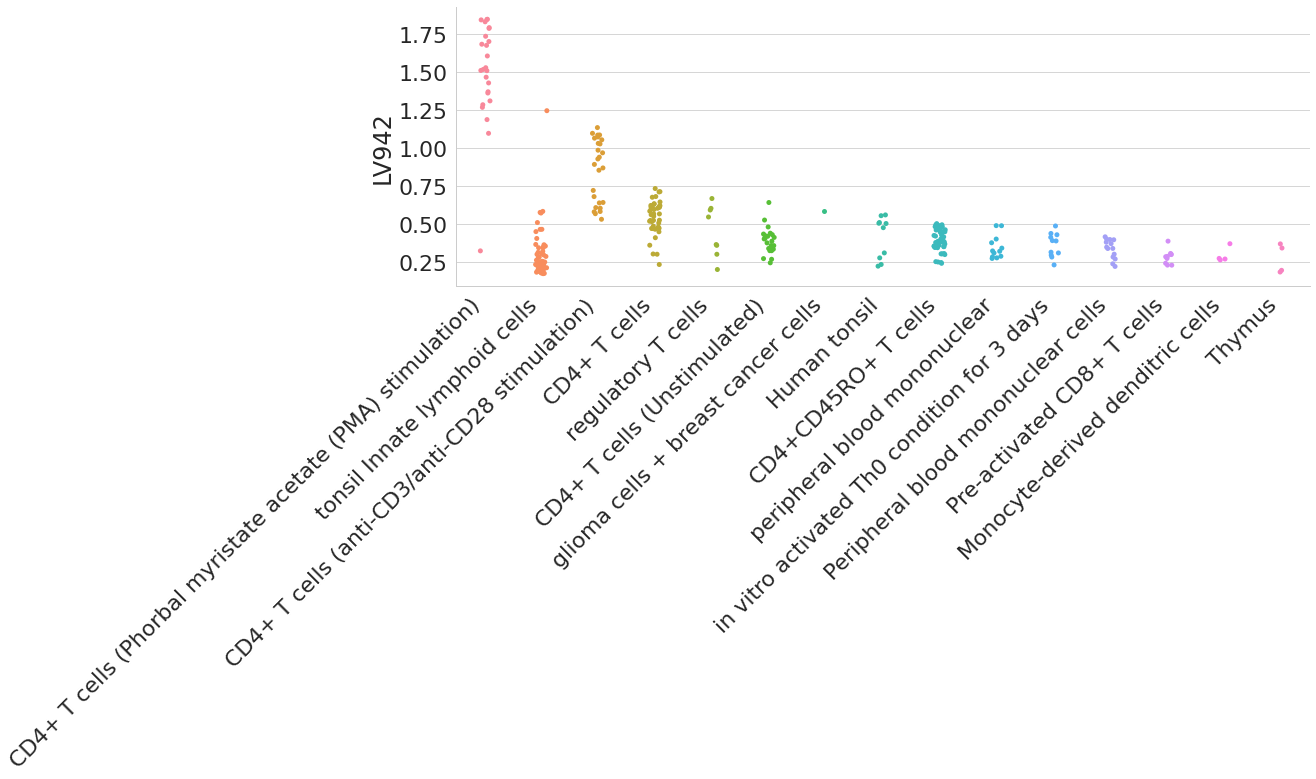

In [72]:
with sns.plotting_context("paper", font_scale=2.5), sns.axes_style("whitegrid"):
    g = sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3.5,
    )
    plt.xticks(rotation=45, horizontalalignment="right")
    plt.xlabel("")

#     plt.savefig(
#         OUTPUT_CELL_TYPE_FILEPATH,
#         bbox_inches="tight",
#         facecolor="white",
#     )

# Debug

In [69]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("NOT CAT")]
#     display(_tmp.head(20))

,,cell type,LV942
project,run,,


In [70]:
# # what is there in these projects?
# lv_data.loc[["SRP056041"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)